In [0]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import os
import cv2 
from PIL import Image
from tqdm import tnrange, tqdm_notebook
import numpy as np
from numpy import moveaxis
import torch
from torch.utils.data.sampler import Sampler
from torch.utils.data import TensorDataset 
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn                                                
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother

torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)

## First step - extracting training data from the timelapse
* This involves trimming the timelapse into four parts 
* Then extracting all the frames from the trimmed videos to be converted to numpy arrays

In [0]:
def trim_video(source_path, start_time, end_time, target_path):
    ffmpeg_extract_subclip(source_path, start_time, end_time, targetname=target_path)

In [0]:
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 32, end_time = 82, target_path = ROOT + "split_labels/gastrula.mp4")
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 116, end_time = 126, target_path = ROOT + "split_labels/comma.mp4")
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 140, end_time = 187, target_path = ROOT + "split_labels/fold.mp4")
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 224, end_time = 240, target_path = ROOT + "split_labels/l1.mp4")



[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 32.00 -t 50.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/gastrula.mp4
... command successful.

[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 116.00 -t 10.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/comma.mp4
... command successful.

[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 140.00 -t 47.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/fold.mp4
... command successful.

[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 224.00 -t 16.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/l1.mp4
... command successful.


In [0]:
def videos_to_frames(video_path, new_folder_path):
    # os.mkdir(new_folder_path)
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = new_folder_path + "/" + str(count)+ ".jpg"
        try:
            cv2.imwrite(fmt_name, image)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", new_folder_path)

In [0]:
videos_to_frames(ROOT + "split_labels/gastrula.mp4", new_folder_path = ROOT + "frames/gastrula")
videos_to_frames(ROOT + "split_labels/comma.mp4", new_folder_path = ROOT + "frames/comma")
videos_to_frames(ROOT + "split_labels/fold.mp4", new_folder_path = ROOT + "frames/fold")
videos_to_frames(ROOT + "split_labels/l1.mp4", new_folder_path = ROOT + "frames/l1")

saved  730  frames at  /content/drive/My Drive/kaggle/GSOC/frames/gastrula
saved  140  frames at  /content/drive/My Drive/kaggle/GSOC/frames/comma
saved  555  frames at  /content/drive/My Drive/kaggle/GSOC/frames/fold
saved  97  frames at  /content/drive/My Drive/kaggle/GSOC/frames/l1


## Generating training data from saved frames
* img_to_arr() takes in the path of an image and returns a numpy array of the image, moveaxis() is optional depending on whether we want to feed it to a CNN or to simply just show it.
* Keep moveaxis = False when you want to plot and view it, or moveaxis = True when it needs to be used for training data


In [0]:
def img_to_arr(im_path, move_axis = True):
    try:
        x = cv2.imread(im_path, 0) 
    except:
        return
    # x = np.array(img)
    if move_axis == True:
        x = moveaxis(x, 2, 0)
    x = x.astype(float)
    return x

In [0]:
def generate_train_data(source_folder, save_path, filename,  label = 0):
    save_path = save_path + filename
    final_stack = []
    c = 0
    for i in tqdm_notebook(os.listdir(source_folder)):   
        
        im_path = source_folder + "/" + i
        im_arr = img_to_arr(im_path, move_axis = False)
        stack_element = [im_arr, label]
        stack_element = np.array(stack_element)
        final_stack.append(stack_element)

    final_stack = np.array(final_stack)
    fmt_name = save_path
    np.save(fmt_name, final_stack)
    print ("saved -- ", fmt_name)

def view_samples_from_training_data(arr, skip_val):
    images = []
    for i in range (0,len(arr), skip_val):
        foo = arr[i][0]
        images.append(foo)
    f = plt.figure(figsize = (25,20))
    for m in range (1,len(images)):
        f.add_subplot(1,len(images), m)
        plt.imshow(images[m])
    plt.show()


## Save all the frames with labels from the folders as numpy arrays
* These portable numpy arrays can be wrapped with the TensorDataset wrapper for training the CNN



In [0]:
generate_train_data(ROOT + "frames/gastrula/", ROOT +  "numpy/", "gastrula.npy",  label = 0)
generate_train_data(ROOT + "frames/comma/", ROOT +  "numpy/", "comma.npy",  label = 1)
generate_train_data(ROOT + "frames/fold/", ROOT + "numpy/", "fold.npy",  label = 2)
generate_train_data(ROOT + "frames/l1/", ROOT + "numpy/", "l1.npy",  label = 3)


saved --  /content/drive/My Drive/kaggle/GSOC/numpy/gastrula.npy



saved --  /content/drive/My Drive/kaggle/GSOC/numpy/comma.npy



saved --  /content/drive/My Drive/kaggle/GSOC/numpy/fold.npy



saved --  /content/drive/My Drive/kaggle/GSOC/numpy/l1.npy


## Loading up the training data 


In [0]:
gastrula = np.array(np.load(ROOT + "numpy/gastrula.npy", allow_pickle = True))
comma = np.array(np.load(ROOT + "numpy/comma.npy", allow_pickle = True))
fold = np.array(np.load(ROOT + "numpy/fold.npy", allow_pickle = True))
l1 = np.array(np.load(ROOT + "numpy/l1.npy", allow_pickle = True))
arr = np.vstack((gastrula, comma, fold, l1))
del gastrula
del comma
del fold
del l1

## Viewing a sample from each of the four categories. 


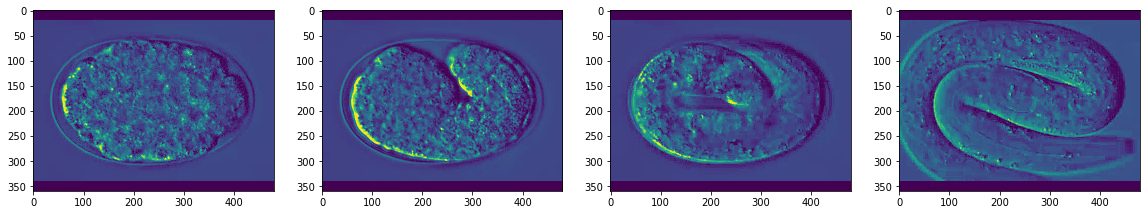

In [0]:
view_samples_from_training_data(arr, 400)

## Splitting training data into images and labels 
* and defining `vis_loss_multi_colors()` , which is basically a poor man's  tensorboard
* try keeping a small batch size, preferably below 64
* a smaller batch size causes noisy updates, but can result in faster learning and a more robust model

In [0]:
def extract_column(arr, index):
    x_train = []
    for m in range (len(arr)):
        x_train.append(arr[m][index])
    return(np.array(x_train))
    
x_train = extract_column(arr,0)
y_train = extract_column(arr,1)

def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()

In [0]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

full_dataset = TensorDataset(x_train_tensor, y_train_tensor)    ## make compatible with DataLoader 

train_size = int(0.9 * len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=27, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=3, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

58 batches 
58  batches 


## Defining the NN architecture
* Larger pool size for max pooling was used because the classifying factors spanned over a relatively larger area, and not in the fine details


In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(5,5)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(10, 10, 3)
        self.conv3 = nn.Conv2d(10, 10, 3)
        
        self.fc1 = nn.Linear(60, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 4)

    def forward(self, x):
        x = (self.pool(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

cellnet = Net()
print(cellnet)


Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=60, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=4, bias=True)
)


## defining the training loop and some lists to collect training metrics
* `StepLR()` decays the learning rate by certain factor gamma after each epoch. It helps prevent random spikes in validation and training loss after the initial few epochs
> step_size can be changed to 2 or any number, which would decay the learning rate after 2 or more required.


In [0]:
losses = []
val_losses = []
avg_losses = []
avg_val_losses = []
optimizer = optim.Adam(cellnet.parameters(), lr = 0.001) 
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)  # lr decreases by 1% aftr every epoch

In [0]:
def calculate_accuracy_on_validation_set(val_loader):
    cellnet.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for x_val, y_val in tqdm_notebook(val_loader, desc = "Running on test set : "):
            total+= 1 
            x_val = x_val.view(-1, 1, 360, 480)        # if torch tensor
            pred = cellnet(x_val)  # pred 
            if torch.argmax(pred).item() == y_val.item():
                correct +=1 
        acc = (correct/total)*100
        return acc

def train_step(x, y):
        optimizer.zero_grad()
        x = x.view(-1, 1, 360, 480)        # if torch tensor
        pred = cellnet(x)
        y = y.long()
        loss = F.cross_entropy(pred,y)
        loss.backward()
        optimizer.step()        
        return loss.item()

def train(epochs):
    
    for m in range (epochs):
        clear_output()
        print ("epoch ", m+1, " out of ", epochs )
        cellnet.train()
        for x_batch, y_batch in tqdm_notebook(train_loader, desc = " Training batches : "):
                loss = train_step(x_batch, y_batch)
                losses.append(loss)
        scheduler.step()   ## lr decay caller 

        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in val_loader:
                y_val =  y_val.long()
                x_val = x_val.view(-1, 1, 360, 480)        # if torch tensor
                yhat =cellnet(x_val)  # pred 
                val_loss = F.cross_entropy(yhat, y_val)
                val_losses.append(val_loss.item())  ## metrics 
        
    vis_loss_multi_colors(losses, val_losses)

epoch  2  out of  2


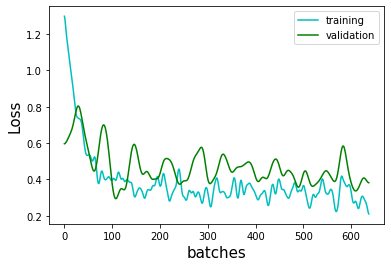

In [12]:
train(2)

## Time to test out the trained model after a few epochs of training.
> accuracy peaks after about 7 epochs on the current architecture


In [0]:
benchmark_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle = True)
print (str(calculate_accuracy_on_validation_set(benchmark_loader)) + " %")

94.4927536231884 %
